### TELEMETRY TANQUES

In [1]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cargamos el exel en un dataframe:

df=pd.read_excel(os.path.join('Telemetry.xlsx'))

In [3]:
# Obtenemos información de las etiquetas de las columnas:

info_column=df.columns.str.split('_')

# Obtenemos el nombre de la primera columna:

column1_name="".join(info_column[0])

# Obtenemos el tamaño del tanque, a partir de la etiqueta de la segunda columna:

tank_size=info_column[1][1]

#Obtenemos los digitos del tamaño:

tank_size=[tank_size[data] for data in range(len(tank_size)) if tank_size[data].isdigit()]
tank_size="".join(tank_size)

#Obtenemos el tipo de gas a partir de la etiqueta de la segunda columna:

gas_name=info_column[1][2]

In [4]:
print(column1_name,tank_size, gas_name,info_column)

Timestamp 19000 LN2 Index([                                                                                ['Timestamp'],
           ['[2574R', 'VRV19000E*', 'LN2', '2826] Tanque - Transmisor de Nivel - Nivel - Contenido'],
       ['[2574R', 'VRV19000E*', 'LN2', '2826] Tanque - Transmisor de presión - Presión - Contenido']],
      dtype='object')


In [5]:
# Cambiamos el nombre de las columnas:

df.columns=['Timestamp','Nivel (%)','Presion (bar)']

In [6]:
# Separamos el timestamp en fecha y hora:

df['Date'] = [d.date() for d in df['Timestamp']]
df['Time'] = [d.time() for d in df['Timestamp']]

In [7]:
# Reordeamos columnas:
df = df.reindex(columns=['Timestamp','Date','Time','Nivel (%)','Presion (bar)'])

# Ordenamos los datos de forma ascendente por fecha y hora:
df=df.sort_values(by=['Date','Time'])
df=df.reset_index(drop=True)

In [8]:
# Cambiamos el formato de la fecha para extraer por año, mes, dia y dia de la semana:
df['Date'] = pd.to_datetime(df['Date'])

df['Year'] = df['Date'].dt.strftime('%Y')
df['Month'] = df['Date'].dt.strftime('%m')
df['Day'] = df['Date'].dt.strftime('%d')
df['Day_of_Week'] = df['Date'].dt.day_name()
df['Month_Name'] = df['Date'].dt.month_name()

In [9]:
def season_selector(date):
    # Obtenemos la estación de año a partir de la fecha.
    season=['Winter','April','Summer','Autum']
    date=datetime.now()
    day=int(date.strftime("%d"))
    month=int(date.strftime("%m"))
    if (month >=1 and month <3) or (month ==12 and day >=21) or (month==3 and day < 21) :
        return season[0]
    if (month >3 and month < 6) or (month==6 and day<21) or (month==3 and day < 21):
        return season[1]
    if (month >6 and month < 9) or (month==6 and day>=21) or (month==9 and day<21):
        return season[2]
    if (month >9 and month < 12) or (month==9 and day >=21) or (month==12 and day<21):
        return season[3]

df['Season'] = df['Date'].apply(season_selector)

In [10]:
#Eliminamos valor 0 de la columna Nivel:
df=df.drop(df.loc[df['Nivel (%)']== 0].index)

In [11]:
# Creamos un columna en el Dataframe llamada Estado:
def inicio(nivel):
    
    num_valores=int(len(df['Nivel (%)']))
    
    if nivel == df['Nivel (%)'].iloc[0]:
        return "Inicio"
    if nivel == df['Nivel (%)'].iloc[(num_valores-1)]:
        return "Fin"
df['Estado']=df['Nivel (%)'].apply(inicio)

In [12]:
#Creamos lista con todos los niveles:
niveles=[nivel for nivel in df['Nivel (%)']]

In [13]:
def descarga_consumo():
    #Creamos una función que nos indica si el valor de nivel corresponde a un estado 
    #de consumo o llenado de la cisterna:

    operacion=['inicio']
    n=1
    while n <(len(niveles)-1):
        if niveles[n] > niveles[n+1] and niveles[n]< niveles[n-1]:
            operacion.append("Consumo")
            #print(f"{niveles[n]} > {niveles[n+1]} y {niveles[n]} < {niveles[n-1]}")
    
        elif niveles[n] < niveles[n+1] and niveles[n]> niveles[n-1]:
            operacion.append("Descarga")
            #print(f"{niveles[n]} < {niveles[n+1]} y {niveles[n]} > {niveles[n-1]}")
        
        elif niveles[n] < niveles[n+1] and niveles[n]< niveles[n-1]:
            if (niveles[n+1]-niveles[n])>0.3 and (niveles[n-1]-niveles[n])>0.3:
                operacion.append("Empieza Descarga")
            else:
                operacion.append("Consumo")
                
            #print(f"{niveles[n]} < {niveles[n+1]} y {niveles[n]} < {niveles[n-1]}")
        
        elif niveles[n] > niveles[n+1] and niveles[n]> niveles[n-1]:
            if (niveles[n]-niveles[n+1])>0.3 and (niveles[n]-niveles[n-1])>0.3:
                operacion.append("Termina Descarga")
            else:
                operacion.append("Consumo")
                
            #print(f"{niveles[n]}> {niveles[n+1]} y {niveles[n]} > {niveles[n-1]}")
        
        elif niveles[n] == niveles[n+1]:
            #print(f"{niveles[n]} == {niveles[n+1]}")
            operacion.append("Sin Consumo")
        
        elif niveles[n] == niveles[n-1]:
            #print(f"{niveles[n]} == {niveles[n-1]}")
            operacion.append("Sin Consumo")
        n+=1
    return operacion

In [14]:
estado= descarga_consumo()

In [15]:
# Hacemos una copia del Dataframe y llenamos el campo Estado con su valor:
dff=df.copy()
mask=dff['Estado']
for n in range(len(estado)):
    mask.iloc[n]=estado[n]

/Users/javiertamarit/.local/share/virtualenvs/Ejercicios_Prog_Avanzada-OvvKQvod/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [16]:
#Exportamos el dataframe a excel:
dff.to_excel(os.path.join('output.xlsx'))

In [17]:
dff.head(70)

,Timestamp,Date,Time,Nivel (%),Presion (bar),Year,Month,Day,Day_of_Week,Month_Name,Season,Estado
0,2021-09-17 10:00:00,2021-09-17,10:00:00,39.84,29.13,2021,09,17,Friday,September,Autum,inicio
1,2021-09-17 11:00:00,2021-09-17,11:00:00,38.41,29.11,2021,09,17,Friday,September,Autum,Consumo
2,2021-09-17 12:00:00,2021-09-17,12:00:00,37.10,29.17,2021,09,17,Friday,September,Autum,Consumo
3,2021-09-17 13:00:00,2021-09-17,13:00:00,36.05,29.22,2021,09,17,Friday,September,Autum,Empieza Descarga
4,2021-09-17 13:30:39,2021-09-17,13:30:39,57.07,NaN,2021,09,17,Friday,September,Autum,Descarga
...,...,...,...,...,...,...,...,...,...,...,...,...
65,2021-09-20 02:00:00,2021-09-20,02:00:00,58.82,32.30,2021,09,20,Monday,September,Autum,Consumo
66,2021-09-20 03:00:00,2021-09-20,03:00:00,58.77,32.35,2021,09,20,Monday,September,Autum,Consumo
67,2021-09-20 04:00:00,2021-09-20,04:00:00,58.66,32.40,2021,09,20,Monday,September,Autum,Consumo
68,2021-09-20 05:00:00,2021-09-20,05:00:00,58.56,32.45,2021,09,20,Monday,September,Autum,Consumo


In [18]:
#Filtra dataframe por descargas:
descargas_df = dff[dff['Estado'] == 'Empieza Descarga']
descargas_df =descargas_df.reset_index(drop=True)

In [19]:
#Obtenemos el número de descargas:
numero_descargas = len(descargas_df)
print(numero_descargas)

13


In [20]:
# Calculamos las deltas de tiempo entre descargas y lo pasamos a una lista:

timestamps=[value for value in descargas_df['Timestamp']]

def delta_time_descargas(timestamps):
    
    delta_time=[0]
    
    for v in range(len(timestamps)-1):
        
        delta= timestamps[v+1]- timestamps[v]
        delta_time.append(delta)
        
    return delta_time

d=delta_time_descargas(timestamps)

In [21]:
#Creamos la columna Delta Time en el Dataframe:
def delta(timestamp):
    if timestamp == descargas_df['Timestamp'].iloc[0]:
        return 0
descargas_df['Delta Time']=descargas_df['Timestamp'].apply(delta)

In [22]:
# Pasamos la lista de Delta Time al Dataframe:
n=1
mask=descargas_df['Delta Time']
while n < numero_descargas:
    mask.iloc[n]=d[n]
    n += 1   

/Users/javiertamarit/.local/share/virtualenvs/Ejercicios_Prog_Avanzada-OvvKQvod/lib/python3.9/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [23]:
# Registo incidencia:
def incident(volumen):
    if volumen < 20.0:
        return "Run Out"
descargas_df['Incidencia']=descargas_df['Nivel (%)'].apply(incident)

In [24]:
descargas_df

,Timestamp,Date,Time,Nivel (%),Presion (bar),Year,Month,Day,Day_of_Week,Month_Name,Season,Estado,Delta Time,Incidencia
0,2021-09-17 13:00:00,2021-09-17,13:00:00,36.05,29.22,2021,09,17,Friday,September,Autum,Empieza Descarga,0.0,None
1,2021-09-20 10:37:30,2021-09-20,10:37:30,54.98,NaN,2021,09,20,Monday,September,Autum,Empieza Descarga,2 days 21:37:30,None
2,2021-09-22 09:00:00,2021-09-22,09:00:00,61.59,29.48,2021,09,22,Wednesday,September,Autum,Empieza Descarga,1 days 22:22:30,None
3,2021-09-24 19:00:00,2021-09-24,19:00:00,53.81,29.23,2021,09,24,Friday,September,Autum,Empieza Descarga,2 days 10:00:00,None
4,2021-09-28 08:00:00,2021-09-28,08:00:00,43.53,29.39,2021,09,28,Tuesday,September,Autum,Empieza Descarga,3 days 13:00:00,None
5,2021-09-30 11:17:15,2021-09-30,11:17:15,54.99,NaN,2021,09,30,Thursday,September,Autum,Empieza Descarga,2 days 03:17:15,None
6,2021-10-02 10:00:00,2021-10-02,10:00:00,48.45,29.03,2021,10,02,Saturday,October,Autum,Empieza Descarga,1 days 22:42:45,None
7,2021-10-04 12:00:00,2021-10-04,12:00:00,36.46,29.09,2021,10,04,Monday,October,Autum,Empieza Descarga,2 days 02:00:00,None
8,2021-10-04 20:30:00,2021-10-04,20:30:00,71.95,NaN,2021,10,04,Monday,October,Autum,Empieza Descarga,0 days 08:30:00,None
9,2021-10-04 20:35:00,2021-10-04,20:35:00,72.08,NaN,2021,10,04,Monday,October,Autum,Empieza Descarga,0 days 00:05:00,None


In [25]:
runouts=descargas_df[descargas_df['Incidencia']=="Run Out"]
num_runouts=len(runouts)

In [26]:
print(num_runouts)

1


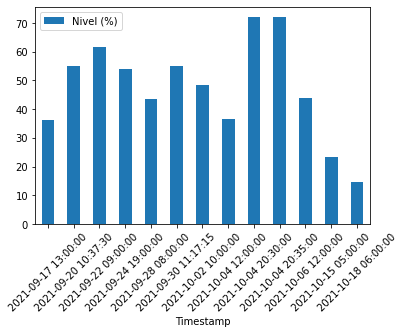

In [27]:
ax = descargas_df.plot.bar(x='Timestamp', y='Nivel (%)', rot= 45)

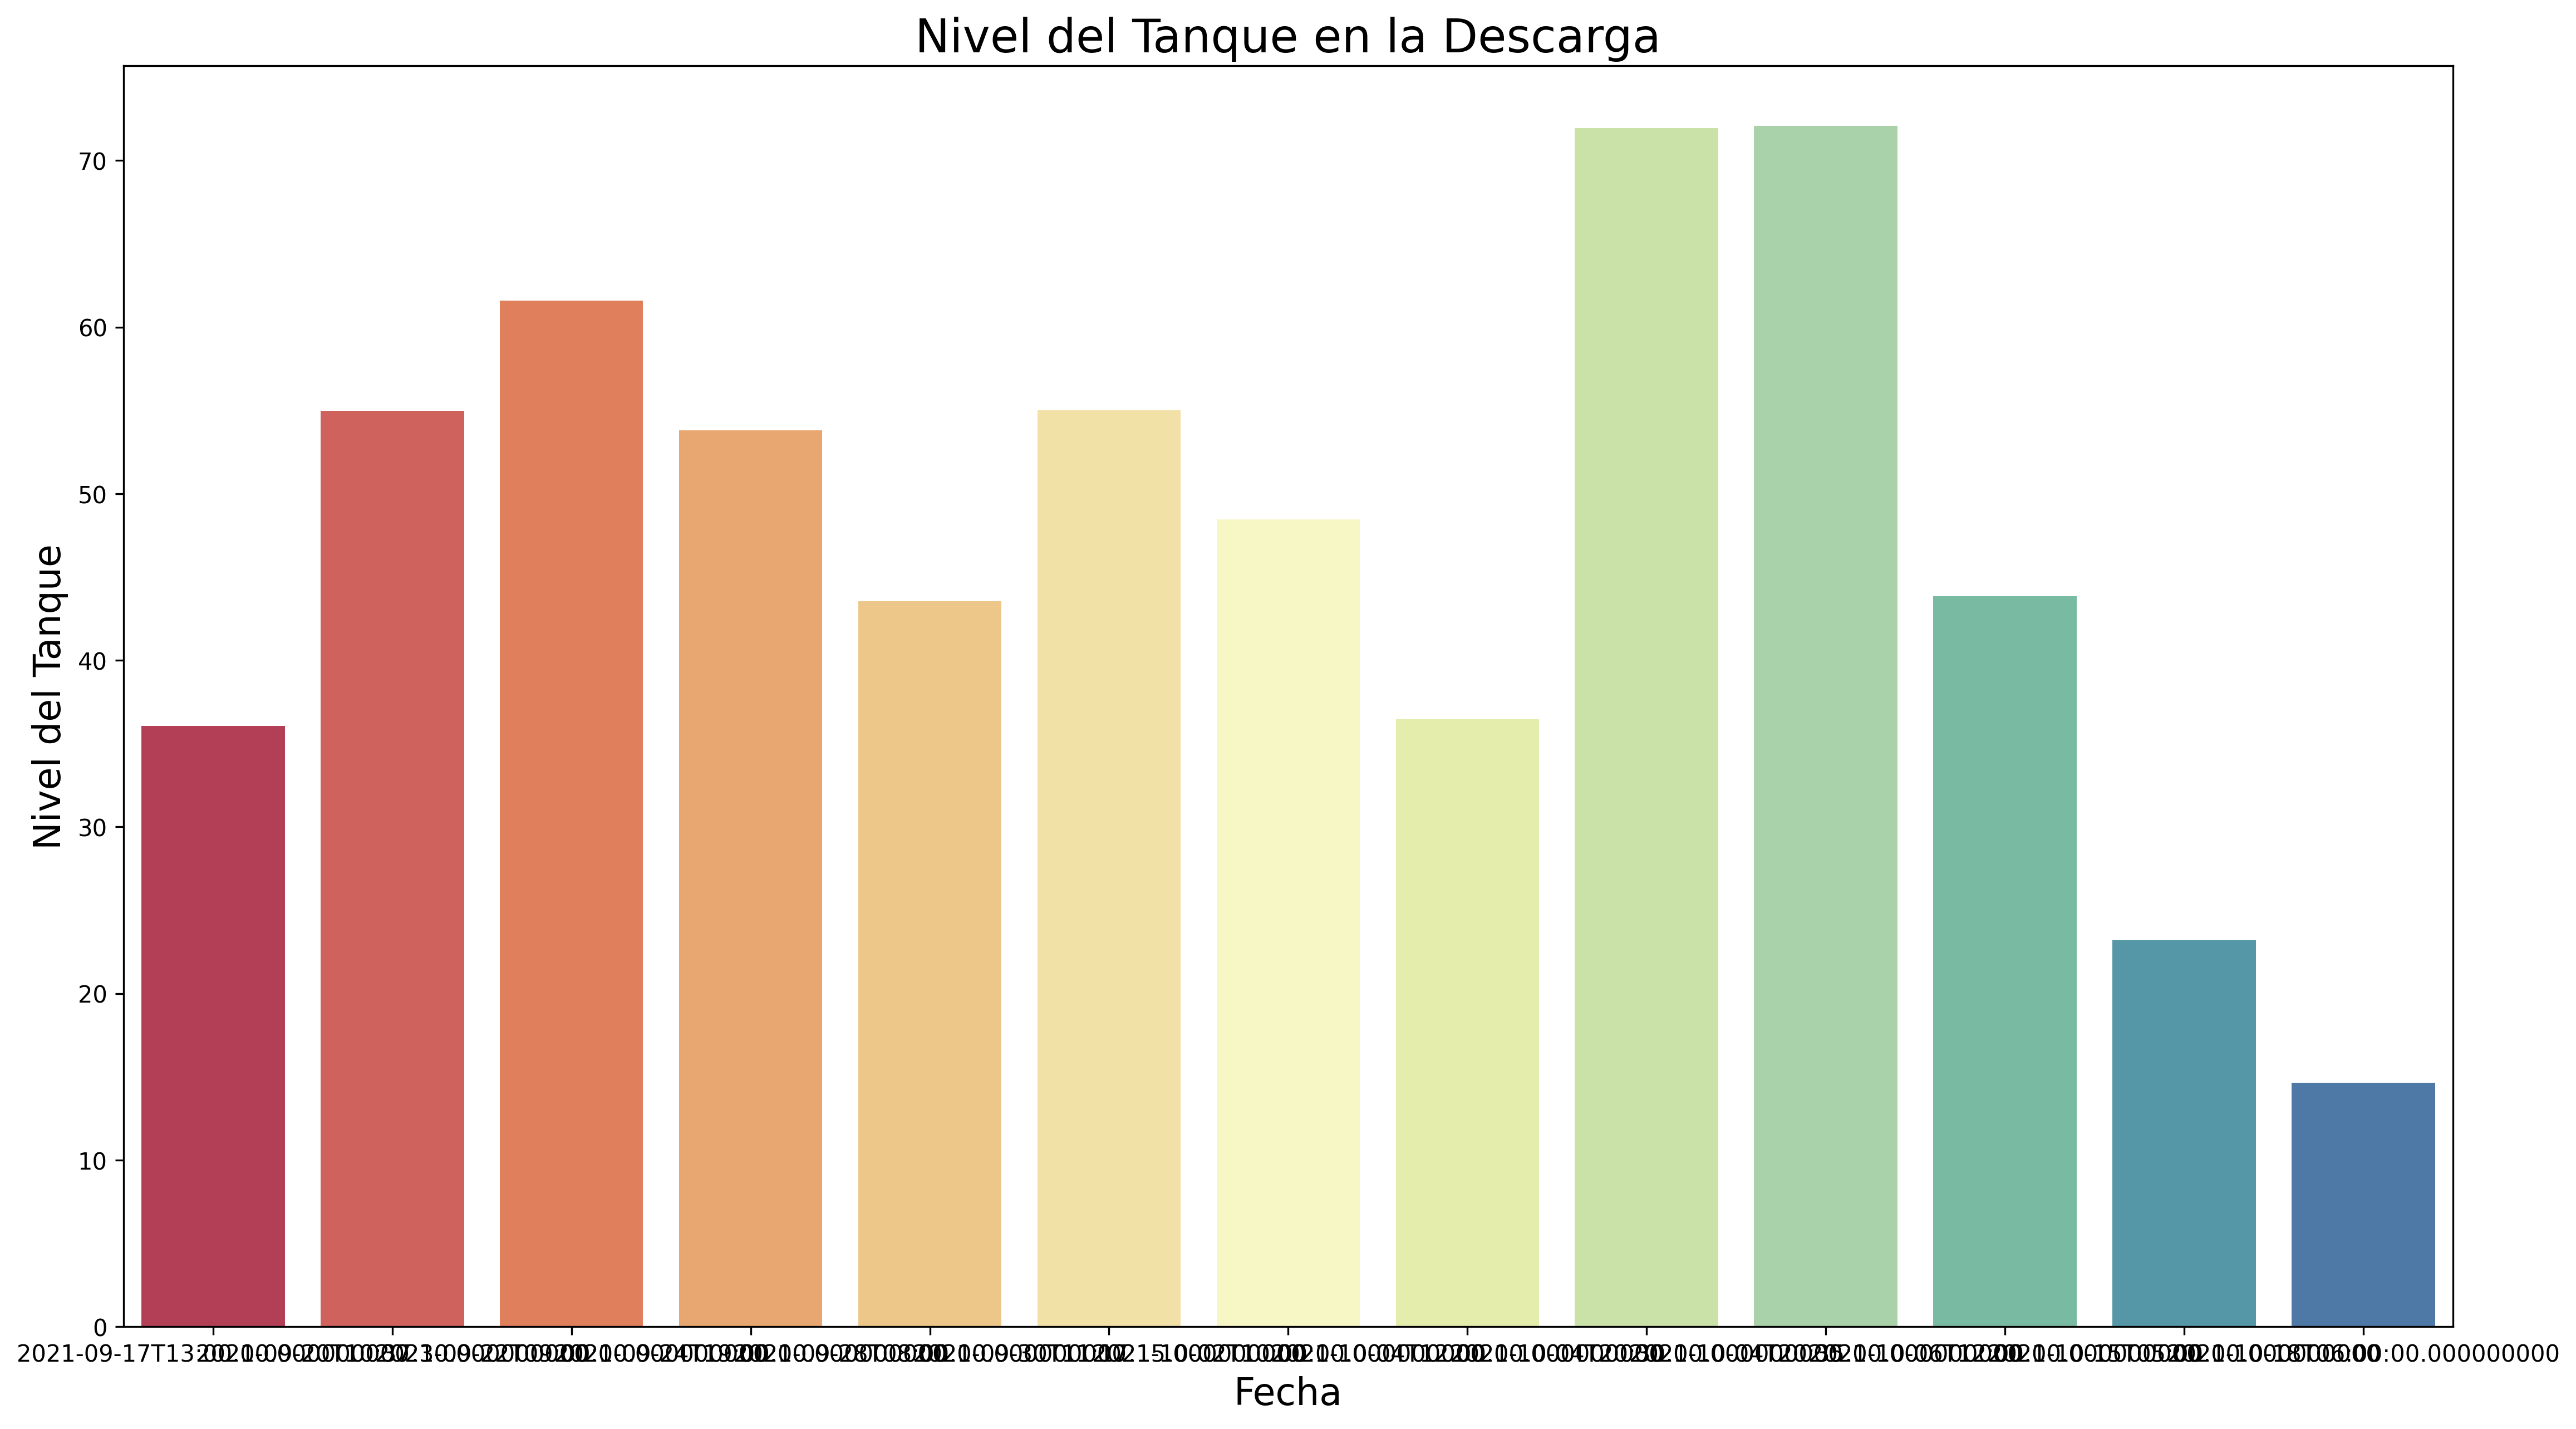

In [28]:
# Graficamos:
fig = plt.figure(figsize=(18,10), dpi=300)
ax = fig.gca()
figure=sns.barplot(x='Timestamp',y='Nivel (%)',data=descargas_df,palette="Spectral")
figure.set_title("Nivel del Tanque en la Descarga",fontsize=20)
plt.xlabel("Fecha", fontsize=16)
plt.ylabel("Nivel del Tanque", fontsize=16)
plt.show()